In [8]:
import pandas as pd
from river import compose
from river import linear_model
from river import metrics
from river import preprocessing
from river import stream
from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.pyplot as plt
import numpy as np
from river import evaluate
from river import optim
import datetime as dt

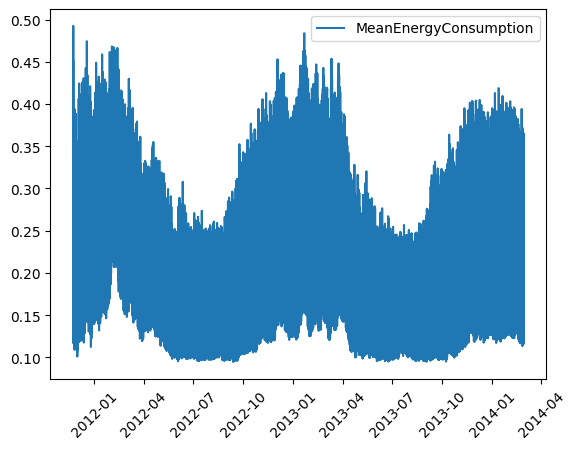

In [9]:
# Load the data
df = pd.read_csv('merged_data.csv')


# Convert the 'utc_timestamp' column to datetime
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Drop the first row
df = df.dropna()

df['day_of_week'] = df['DateTime'].dt.dayofweek
df['hour_of_day'] = df['DateTime'].dt.hour
df['month'] = df['DateTime'].dt.month

df

#plot the data
plt.plot(df['DateTime'], df['MeanEnergyConsumption'])
#update plot to have legend
plt.legend(['MeanEnergyConsumption'])
#rotate x-axis labels
plt.xticks(rotation=45)
plt.show()

In [10]:
#check for break in timestamps
import pandas as pd

# Assuming df is your DataFrame and 'timestamp' is your timestamp column
df = df.sort_values('DateTime')

# Calculate the difference between current and previous timestamp
df['time_diff'] = df['DateTime'].diff()

# Define a threshold for a break, e.g., 1 hour
threshold = pd.Timedelta(hours=1)

# Check if there are any breaks
has_breaks = any(df['time_diff'] > threshold)

print(f"Data has breaks: {has_breaks}")

Data has breaks: False


In [11]:
#df['MeanEnergyConsumption'].plot()

#drop the utc_timestamp column
#df = df.drop('utc_timestamp', axis=1)

stream = iter(df.itertuples(index=False))
stream = iter([(x._asdict(), y) for x, y in zip(df.drop('MeanEnergyConsumption', axis=1).itertuples(index=False), df['MeanEnergyConsumption'])])
print(next(stream))

({'DateTime': Timestamp('2011-11-23 09:00:00'), 'temperature_2m': 4.25, 'precipitation': 0.0, 'cloud_cover': 30.300001, 'cloud_cover_low': 1.0, 'cloud_cover_mid': 0.0, 'cloud_cover_high': 98.0, 'is_day': 1.0, 'sunshine_duration': 2924.7007, 'day_of_week': 2, 'hour_of_day': 9, 'month': 11, 'time_diff': NaT}, 0.355)


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from river import neural_net
from river import neighbors

# Create a pipeline that includes scaling the target variable
model = compose.Pipeline(
    compose.Select('hour_of_day', 'month', 'day_of_week','temperature_2m', 'precipitation','cloud_cover','cloud_cover_low','cloud_cover_mid','cloud_cover_high','is_day','sunshine_duration'),
    preprocessing.StandardScaler(),
    preprocessing.TargetStandardScaler(
        regressor=neighbors.KNNRegressor(
            n_neighbors=16,
            aggregation_method = 'weighted_mean',
        )
    )
)

# Evaluate the model
steps = evaluate.iter_progressive_val_score(
    dataset=stream,
    model=model,
    metric=metrics.MAE(),
    moment='DateTime',
    delay=dt.timedelta(days=7),
    step=1,
    yield_predictions=True,
)

start_date =  df['DateTime'].min()
end_date =  df['DateTime'].max()
# Initialize lists to store the predictions and their timestamps
predictions = []
timestamps = pd.date_range(start=start_date, end=end_date, freq='1h')
#remove the first timestamp
timestamps = timestamps[1:]
Mea_overtime = []
print(steps)
length = 0

for step in steps:
    
    length += 1
    predictions.append(step["Prediction"])
    Mea_overtime.append(str(step["MAE"]).split(" ")[1])
print(step)

#convert mea_overtime to a list of floats
Mea_overtime = [float(i) for i in Mea_overtime]

# Plot the predictions
fig, ax = plt.subplots()
# Also plot the actual values with transparency and a label for the legend
ax.plot_date(mdates.date2num(df['DateTime']), df['MeanEnergyConsumption'], linestyle='-', marker=None, alpha=0.5, label='Actual Values')
# Plot the predictions with transparency and a label for the legend
ax.plot_date(mdates.date2num(timestamps), predictions, linestyle='-', marker=None, alpha=0.5, label='Predictions')
ax.set_title('Energy Consumption over Time with a 7-day Delay (knn(16) Mean Aggregation)')
ax.set_ylabel('Energy Consumption (kWh)')
ax.set_xlabel('Date')
fig.autofmt_xdate()
ax.legend()
plt.show()


#plotting of the predictions and actual values for a week

# Define the start and end dates
start_date = pd.to_datetime('2013-01-01')
end_date = start_date + pd.DateOffset(weeks=1)
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Filter the data
week_data = df[(df['DateTime'] >= start_date) & (df['DateTime'] < end_date)]

#combine the predictions and timestamps into a dataframe
df_prediction = pd.DataFrame({'DateTime': timestamps, 'Predictions': predictions})

#convert datetime to datetime object
df_prediction['DateTime'] = pd.to_datetime(df_prediction['DateTime'])
week_predictions = df_prediction[(df_prediction['DateTime'] >= start_date) & (df_prediction['DateTime'] < end_date)]
fig, ax = plt.subplots()

# Also plot the actual values with transparency and a label for the legend
ax.plot_date(mdates.date2num(week_data['DateTime']), week_data['MeanEnergyConsumption'], linestyle='-', marker=None, label='Actual Values')

# Plot the predictions with transparency and a label for the legend
ax.plot_date(mdates.date2num(week_predictions['DateTime']), week_predictions['Predictions'], linestyle='-', marker=None, label='Predictions')
ax.set_ylabel('Energy Consumption (kWh)')
ax.set_xlabel('Date')
ax.legend()
ax.set_title('Energy Consumption 7-day Delay (knn(16) Mean Aggregation)')

# Rotate date labels automatically
fig.autofmt_xdate()

plt.show()


#plot the RMSE 
plt.plot(Mea_overtime)
plt.xlabel('Time Step')
plt.ylabel('MEA')
plt.title('MEA Over Time')
plt.show()


import numpy as np


# Plot the predictions
fig, ax = plt.subplots()
# Also plot the actual values with transparency and a label for the legend
ax.plot_date(mdates.date2num(df['DateTime']), df['MeanEnergyConsumption'], linestyle='-', marker=None, alpha=0.5, label='Actual Values')
# Plot the predictions with transparency and a label for the legend
ax.plot_date(mdates.date2num(timestamps), predictions, linestyle='-', marker=None, alpha=0.5, label='Predictions')
ax.set_title('Energy Consumption over Time with a 7-day Delay (knn(16) Mean Aggregation)')
ax.set_ylabel('Energy Consumption (kWh)')
ax.set_xlabel('Date')
fig.autofmt_xdate()
ax.legend()
plt.show()

# Scatter plot of the actual vs predicted values
plt.figure(figsize=(10, 5))
plt.scatter(df['MeanEnergyConsumption'][1:], predictions, label='True vs Predicted')

# Add a red line for perfect predictions
min_val = min(min(df['MeanEnergyConsumption'][1:]), min(predictions))
max_val = max(max(df['MeanEnergyConsumption'][1:]), max(predictions))
plt.plot([min_val, max_val], [min_val, max_val], color='red')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.grid(True)
plt.legend()
plt.show()


df_prediction.to_csv(f'knn_16_predictions.csv', index=False)


<generator object iter_progressive_val_score at 0x000001BCD5F66EA0>


KeyError: 'RMSE'

In [ ]:
from river import evaluate
from river.stream import iter_pandas


model = compose.Pipeline(
    compose.Select('hour_of_day', 'month', 'day_of_week','temperature_2m', 'precipitation','cloud_cover','cloud_cover_low','cloud_cover_mid','cloud_cover_high','is_day','sunshine_duration'),
    preprocessing.StandardScaler(),
    preprocessing.TargetStandardScaler(
        regressor=neighbors.KNNRegressor(
            n_neighbors=16,
            aggregation_method = 'weighted_mean',
        )
    )
)

# Define the number of folds for the rolling window cross-validation
n_folds = 5

# Calculate the size of each fold
fold_size = len(df) // n_folds

# Initialize a list to store the RMSE for each fold
rmse_scores = []

# Perform the rolling window cross-validation
for i in range(n_folds):
    # Define the start and end of the training data
    train_start = i * fold_size
    train_end = train_start + fold_size

    # Define the validation data as the next step after the training data
    val_start = train_end
    val_end = val_start + fold_size

    # Split the data into training and validation sets
    train_data = df.iloc[train_start:train_end]
    val_data = df.iloc[val_start:val_end]

    # Convert the training and validation sets to a stream
    train_stream = iter_pandas(X=train_data.drop('MeanEnergyConsumption', axis=1), y=train_data['MeanEnergyConsumption'])
    val_stream = iter_pandas(X=val_data.drop('MeanEnergyConsumption', axis=1), y=val_data['MeanEnergyConsumption'])

    # Clone the model for each fold
    model_clone = model.clone()

    # Train the model on the training data
    for x, y in train_stream:
        model_clone.learn_one(x, y)

    # Initialize a list to store the predictions
    predictions = []

    # Use the model to make predictions on the validation data
    for x, y in val_stream:
        y_pred = model_clone.predict_one(x)
        predictions.append(y_pred)

    rmse_metric = metrics.RMSE()
    for y_true, y_pred in zip(val_data['MeanEnergyConsumption'], predictions):
        rmse_metric.update(y_true, y_pred)
    rmse = rmse_metric.get()

    # Store the RMSE for this fold
    rmse_scores.append(rmse)

# Calculate the average RMSE across all folds
average_rmse = sum(rmse_scores) / n_folds

print(f'Average RMSE: {average_rmse}')

Average RMSE: 0.06946116574373144


19864
4


ValueError: x and y must be the same size

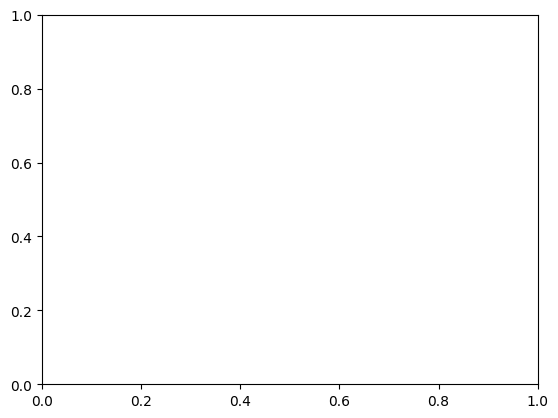

In [ ]:
import matplotlib.pyplot as plt

# Create a scatter plot
length = len(df['MeanEnergyConsumption'])
print(length)
print(len(predictions))

#copy df to a new dataframe that drops the first row
df_new = df[1:]

plt.scatter(df_new['MeanEnergyConsumption'], predictions)

# Create a 45 degree line
max_value = max(max(df_new['MeanEnergyConsumption']), max(predictions))
plt.plot([0, max_value], [0, max_value], color='red')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')

plt.show()

In [ ]:
from river import optim
from river import evaluate
from sklearn.model_selection import ParameterGrid
stream = iter(df.itertuples(index=False))
stream = iter([(x._asdict(), y) for x, y in zip(df.drop('MeanEnergyConsumption', axis=1).itertuples(index=False), df['MeanEnergyConsumption'])])
# Define the parameter grid

learning_rate = [1,2,0.5,4,10,0.1]
NumberofNeighbeurs = [16,18,20]

param_grid = {'n_neighbors': NumberofNeighbeurs,
              'Aggregation_method': ['mean','median','weighted_mean'],
              'scaler': [preprocessing.StandardScaler(),preprocessing.AdaptiveStandardScaler(),preprocessing.MaxAbsScaler() , preprocessing.MinMaxScaler()],
              }

# Initialize the best MAE and learning rate
best_mae = float('inf')
best_lr = None


ListOfListOfPredictions = []
listofParams = []
# Iterate over the parameter grid
for params in ParameterGrid(param_grid):
    print(f'testing {params["n_neighbors"]} KNN with {params["Aggregation_method"]} Aggregation, {params["scaler"]} scaler')
    # Create a new model with the current learning rate
    model = compose.Pipeline(
        compose.Select('hour_of_day', 'month', 'day_of_week','temperature_2m', 'precipitation','cloud_cover','cloud_cover_low','cloud_cover_mid','cloud_cover_high','is_day','sunshine_duration'),
        params['scaler'],
        preprocessing.TargetStandardScaler(
            regressor=neighbors.KNNRegressor(
                n_neighbors=params['n_neighbors'],
                aggregation_method = params['Aggregation_method'],
            )
        )
    )
    
    # Evaluate the model
    steps = evaluate.iter_progressive_val_score(
        dataset=stream,
        model=model.clone(),
        metric=metrics.MAE(),
        moment='DateTime',
        delay=dt.timedelta(days=7),
        step=1,
        yield_predictions=True,
    )
    
    

    stream = iter(df.itertuples(index=False))
    stream = iter([(x._asdict(), y) for x, y in zip(df.drop('MeanEnergyConsumption', axis=1).itertuples(index=False), df['MeanEnergyConsumption'])])
    
    # Initialize lists to store the predictions and their timestamps
    predictions = []
    lastMean = 0
    for step in steps:
        predictions.append(step["Prediction"])
        lastMean = step["MAE"]
        
    ListOfListOfPredictions.append(predictions)
    listofParams.append(params)
    
    
    #print(float(str(mae).split(" ")[1]))
    # If the current MAE is better than the best MAE, update the best MAE and learning rate
    
    #convert mean to float
    print(lastMean)
    lastMean = float(str(lastMean).split(" ")[1])
    
    if lastMean != 0 and lastMean < best_mae:
        best_mae = lastMean
        best_lr = params['n_neighbors']
        bestAggregation_method = params['Aggregation_method']
        bestscaler = params['scaler']
        
        
 
print(f'Best MAE: {best_mae}')
print(f'Best Number of neighburs: {best_lr}')
print(f'Best Aggregation method: {bestAggregation_method}')
print(f'Best scaler: {bestscaler}')



#plotting of the predictions and actual values for a week

start_date =  df['DateTime'].min()
end_date =  df['DateTime'].max()
# Initialize lists to store the predictions and their timestamps
predictions = []
timestamps = pd.date_range(start=start_date, end=end_date, freq='1h')

for predictions,params in zip(ListOfListOfPredictions,listofParams):
    # Define the start and end dates
    start_date = pd.to_datetime('2013-01-01')
    end_date = start_date + pd.DateOffset(weeks=1)
    df['DateTime'] = pd.to_datetime(df['DateTime'])

    # Filter the data
    week_data = df[(df['DateTime'] >= start_date) & (df['DateTime'] < end_date)]

    #combine the predictions and timestamps into a dataframe
    df_prediction = pd.DataFrame({'DateTime': timestamps, 'Predictions': predictions})

    #convert datetime to datetime object
    df_prediction['DateTime'] = pd.to_datetime(df_prediction['DateTime'])
    week_predictions = df_prediction[(df_prediction['DateTime'] >= start_date) & (df_prediction['DateTime'] < end_date)]
    fig, ax = plt.subplots()

    # Also plot the actual values with transparency and a label for the legend
    ax.plot_date(mdates.date2num(week_data['DateTime']), week_data['MeanEnergyConsumption'], linestyle='-', marker=None, label='Actual Values')

    # Plot the predictions with transparency and a label for the legend
    ax.plot_date(mdates.date2num(week_predictions['DateTime']), week_predictions['Predictions'], linestyle='-', marker=None, label='Predictions')
    ax.set_ylabel('Energy Consumption (kWh)')
    ax.set_xlabel('Date')
    ax.legend()
    ax.set_title(f'{params["n_neighbors"]} KNN with {params["Aggregation_method"]}, {params["scaler"]}')

    # Rotate date labels automatically
    fig.autofmt_xdate()

    plt.show()





testing 16 KNN with mean Aggregation, StandardScaler scaler
MAE: 0.034152
testing 16 KNN with mean Aggregation, AdaptiveStandardScaler scaler


KeyboardInterrupt: 